# PIPELINE FINALE

## Initialisation de la pipeline

### 0.1 - Import des librairies nécéssaires au code

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import shutil
import pickle
import collections
import random

from glob import glob
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image, UnidentifiedImageError
from tensorflow import keras
from tensorflow.keras.models import load_model

### 0.2 - Définition des constantes

In [ ]:
# -------------------------------- General Parameters
SEED = 42
# -------------------------------- Images Parameters
IMAGE_H = 128
IMAGE_W = 128
BATCH_S = 16
# -------------------------------- Classes indexes
PAINTING_IDX = 0
PHOTO_IDX = 1
SCHEMA_IDX = 2
SKETCH_IDX = 3
TEXT_IDX = 4
# -------------------------------- Folders
DATASET_DIRECTORY = "dataset_livrable_1/"
PHOTOS_DIRECTORY = "final_pipeline/photos"
DENOISED_PHOTOS_DIRECTORY = "final_pipeline/denoised_photos"
MODEL_DIRECTORY = "models"
# -------------------------------- Model names
CLASSIFICATION_MODEL_NAME = "classification_model.keras"
AUTOENCODER_MODEL_NAME = "autoencoder_model.keras"
CAPTIONNING_MODEL_NAME = "captionning_model.keras"
# -------------------------------- Model paths
CLASSIFICATION_MODEL_PATH = os.path.join(MODEL_DIRECTORY, CLASSIFICATION_MODEL_NAME)
AUTOENCODER_MODEL_PATH = os.path.join(MODEL_DIRECTORY, AUTOENCODER_MODEL_NAME)
CAPTIONNING_MODEL_PATH = os.path.join(MODEL_DIRECTORY, CAPTIONNING_MODEL_NAME)

### 0.3 - Définition des classes

In [ ]:
@tf.keras.utils.register_keras_serializable('CNN_Encoder')
class CNN_Encoder(tf.keras.Model):
    # Comme les images sont déjà prétraités par InceptionV3 est représenté sous forme compacte
    # L'encodeur CNN ne fera que transmettre ces caractéristiques à une couche dense
    def __init__(self, embedding_dim, **kwargs):
        super(CNN_Encoder, self).__init__(**kwargs)
        self.embedding_dim = embedding_dim
        # forme après fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
    def get_config(self):
        config = super(CNN_Encoder, self).get_config()
        config.update({
            'embedding_dim': self.embedding_dim,
        })
        return config

In [ ]:
@tf.keras.utils.register_keras_serializable('BahdanauAttention')
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) forme == (batch_size, 64, embedding_dim)

        # forme de la couche cachée == (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        attention_hidden_layer = tf.nn.tanh(
                self.W1(features) + self.W2(hidden_with_time_axis)
        )

        # Cela vous donne un score non normalisé pour chaque caractéristique de l'image.
        score = self.V(attention_hidden_layer)

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights
    
    def get_config(self):
        config = super(BahdanauAttention, self).get_config()
        config.update({
            units: self.units,
        })
        return config

In [ ]:
@tf.keras.utils.register_keras_serializable('RNN_Decoder')
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, use_lstm=False, **kwargs):
        super(RNN_Decoder, self).__init__(**kwargs)
        self.units = units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.use_lstm = use_lstm

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        if not use_lstm:
            self.layer = tf.keras.layers.GRU(
                self.units,
                return_sequences=True,
                return_state=True,
                activation='tanh',
                recurrent_activation='sigmoid',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                recurrent_initializer='orthogonal',
                bias_initializer='zeros',
                unroll=True,
            )
        else:
            self.layer = tf.keras.layers.LSTM(
                self.units,
                return_sequences=True,
                return_state=True,
                activation='tanh',
                recurrent_activation='sigmoid',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                recurrent_initializer='orthogonal',
                bias_initializer='zeros',
                unroll=True,
            )

        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        context_vector = tf.expand_dims(context_vector, 1)
        
        x = tf.concat([context_vector, x], axis=-1)

        if not self.use_lstm:
            x = self.fc1(x)
            output, state = self.layer(x)
            y = tf.reshape(output, (-1, output.shape[2]))
        else:
            output, state, _ = self.layer(x)
            y = self.fc1(output)
            y = tf.reshape(y, (-1, y.shape[2]))

        y = self.fc2(y)

        return y, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

    def get_config(self):
        config = super(RNN_Decoder, self).get_config()
        config.update({
            'embedding_dim': self.embedding_dim,
            'units': self.units,
            'vocab_size': self.vocab_size,
            'use_lstm': self.use_lstm
        })
        return config

### 0.4 - Définition des fonctions

In [ ]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)


In [ ]:

# Définition de la fonction load_image
def load_image(image_path):
    """
    La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
    contenant l'image traitée ainsi que son chemin d'accès.
    La fonction load_image effectue les traitement suivant:
        1. Chargement du fichier correspondant au chemin d'accès image_path
        2. Décodage de l'image en RGB.
        3. Redimensionnement de l'image en taille (299, 299).
        4. Normalisation des pîxels de l'image entre -1 et 1
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
def is_image(filename):
    try:
        with Image.open(filename) as img:
            img.verify()
        return True
    except (UnidentifiedImageError, OSError):
        return False
def move_non_images(directory):
    dump_directory = "dump"
    os.makedirs(dump_directory, exist_ok = True)
    
    for folder, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(folder, file)
            if not is_image(file_path):
                print(f"Déplacement de {file_path} dans le dossier dump/")
                dest_path = os.path.join(dump_directory, file)
                try:
                    shutil.move(file_path, dest_path)
                except:
                    print("Erreur lors du déplacement")
def is_valid_image(path):
    try:
        img_raw = tf.io.read_file(path)
        _ = tf.image.decode_image(img_raw, channels=3)
        return (path, True)
    except Exception:
        return (path, False)
def clean_corrupted_images(directory, extensions=("jpg", "jpeg", "png"), max_workers=8):
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(extensions):
                image_paths.append(os.path.join(root, file))

    print(f"Scan de {len(image_paths)} images dans {directory}")

    corrupted_count = 0
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(is_valid_image, path) for path in image_paths]
        for future in as_completed(futures):
            path, is_valid = future.result()
            if not is_valid:
                try:
                    os.remove(path)
                    corrupted_count += 1
                except Exception as e:
                    print(f"Erreur de suppression {path} : {e}")

    print(f"Vérification terminée : {corrupted_count} image(s) corrompue(s) supprimée(s).")

## Partie 1 : Classification

### 1.0 - Mise au propre des folders & tri des fichiers

In [ ]:
# move_non_images(DATASET_DIRECTORY)

# clean_corrupted_images(DATASET_DIRECTORY)

# Remove Photos from previous iteration
if not os.path.exists('final_pipeline'):
    os.mkdir('final_pipeline')
for dir in [
    PHOTOS_DIRECTORY, 
    DENOISED_PHOTOS_DIRECTORY,
    ]:  
    # Remove the directory if it exists
    if os.path.exists(dir):
        shutil.rmtree(dir) 
    # Create the directory
    if not os.path.exists(dir):
        os.mkdir(dir)

### 1.1 - Import des données source

In [ ]:
dataset = keras.utils.image_dataset_from_directory(
    DATASET_DIRECTORY,
    batch_size = BATCH_S,
    image_size = (IMAGE_H, IMAGE_W),
    label_mode = None,
    seed = 42,
    validation_split = None,
    subset = None,
    shuffle = None,
)
filepaths = dataset.file_paths

### 1.2 - Classification des données

In [ ]:
# filter_model = load_model('../model_basic_cnn.keras')
classification_model = load_model(CLASSIFICATION_MODEL_PATH)

In [ ]:
predicts = classification_model.predict(dataset, verbose = 1)
y_pred = []
y_pred.extend(predicts.argmax(axis=1))

### 1.3 - Copie des photos dans un répertoire spécifique

In [ ]:
images_preds = list(zip(filepaths, y_pred))
photos_preds = list(filter(lambda x: x[1] == PHOTO_IDX,images_preds))

for filepath, prediction in images_preds:
    if prediction == PHOTO_IDX:
        filename = os.path.basename(filepath)
        # print(filename)
        dest_path = os.path.join(PHOTOS_DIRECTORY, filename)
        shutil.copy(filepath, dest_path)

## Partie 2 : Dénoising des images

### 2.0 - Import des données

In [ ]:
dataset = keras.utils.image_dataset_from_directory(
    directory = PHOTOS_DIRECTORY,
    batch_size = BATCH_S,
    image_size = (IMAGE_H, IMAGE_W),
    label_mode = None,
    seed = 42,
    validation_split = None,
    subset = None,
    shuffle = None,
)
filepaths = dataset.file_paths

In [ ]:
dataset = dataset.map(lambda x: tf.cast(x, tf.float32) / 255.0)
X = []
for batch in dataset:
    X.append(batch.numpy())
dataset = np.concatenate(X)

### 2.1 - Denoising des images sources

In [ ]:
# load model from file
autoencoder_model = load_model(AUTOENCODER_MODEL_PATH)

In [ ]:
denoised_images = autoencoder_model.predict(dataset, verbose = 1)

In [ ]:
plt.imshow(denoised_images[1])
plt.axis("off")
plt.show()

### 2.2 - Sauvegarde des images

In [ ]:
# save images from denoised_images
for i, image in enumerate(denoised_images):
    # Convert the image to uint8 format
    image = (image * 255).astype(np.uint8)
    # Create a PIL Image from the numpy array
    pil_image = Image.fromarray(image)
    # Save the image
    filename = os.path.basename(filepaths[i])
    dest_path = os.path.join(DENOISED_PHOTOS_DIRECTORY, filename)
    pil_image.save(dest_path)

## Partie 3 : Captioning des images

### 3.0 - Import des données

In [28]:
dataset = keras.utils.image_dataset_from_directory(
    directory = DENOISED_PHOTOS_DIRECTORY,
    label_mode = None,
    batch_size = BATCH_S,
    image_size = (IMAGE_H, IMAGE_W),
    seed = 42
)
filepaths = dataset.file_paths

Found 9574 files.


### 3.1 - Prétraitement des données

In [29]:
# Telechargement du modèle InceptionV3 pré-entrainé avec la cassification sur ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
# Creation d'une variable qui sera l'entrée du nouveau modèle de pre-traitement d'images
new_input = image_model.input
# récupérer la dernière couche caché qui contient l'image en representation compacte
hidden_layer = image_model.layers[-1].output

# Modèle qui calcule une representation dense des images avec InceptionV3
image_features_extract_model = tf.keras.Model(inputs = new_input, outputs = hidden_layer)


# Pré-traitement des images
image_dataset = tf.data.Dataset.from_tensor_slices(filepaths[:200])
# Division du données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Parcourir le dataset batch par batch pour effectuez le pré-traitement d'InceptionV3
for img, path in tqdm(image_dataset):
    # Pré-traitement du batch (de taille (16,8,8,2048)) courant par InceptionV3 
    batch_features = image_features_extract_model(img)
    # Resize du batch de taille (16,8,8,2048) en taille (16,64,2048)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    # Parcourir le batch courant et stocker le chemin ainsi que le batch avec np.save()
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # (chemin de l'image associe a sa nouvelle representation , representation de l'image)
        np.save(path_of_feature, bf.numpy())

100%|██████████| 13/13 [00:27<00:00,  2.10s/it]


### 3.2 - Import des classes

In [ ]:
# loading
embedding_dim = 256
units = 512
max_length = 15
features_shape = 2048
attention_features_shape = 64

with open('models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
vocab_size = 5000 + 1


encoder = CNN_Encoder(embedding_dim)
decoderLSTM = RNN_Decoder(embedding_dim, units, vocab_size, use_lstm=True)


In [ ]:
# Build the models by calling them with dummy data
dummy_image_features = tf.random.normal([1, attention_features_shape, features_shape])
dummy_caption_input = tf.random.uniform([1, 1], minval=0, maxval=vocab_size, dtype=tf.int32)
dummy_hidden_state = tf.zeros((1, units))

# Build the encoder by calling it with dummy data
_ = encoder(dummy_image_features)

# Build the decoder by calling it with dummy data
dummy_encoder_output = encoder(dummy_image_features)
_ = decoderLSTM(dummy_caption_input, dummy_encoder_output, dummy_hidden_state)

In [ ]:
encoder.load_weights("models/encoder.weights.h5")
decoderLSTM.load_weights("models/decoder_lstm.weights.h5")

### 3.3 Génération des captions

In [62]:
def evaluate(image, decoder):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        try:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

            attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

            predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
            
            result.append(tokenizer.index_word[predicted_id])
        
            if tokenizer.index_word[predicted_id] == '<end>':
                break
            
            dec_input = tf.expand_dims([predicted_id], 0)
        except KeyError:
            print("KeyError: predicted_id not in tokenizer")

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [63]:
# Fonction pour valider une légende
def is_valid_caption(caption):
    words = caption.split()

    # Critère 1 : au moins 5 mots
    if len(words) < 5:
        return False

    # Critère 2 : au moins 3 mots de au moins 5 lettres
    long_words = [w for w in words if len(w) >= 5]
    if len(long_words) < 3:
        return False

    # Critère 3 : pas plus de 2 occurrences du même mot
    lower_words = [w.lower() for w in words]
    word_counts = collections.Counter(lower_words)
    if any(count > 2 for count in word_counts.values()):
        return False

    return True

KeyError: predicted_id not in tokenizer
Image Path: final_pipeline/denoised_photos\photo_3648.jpg
LSTM Predictions:
LSTM Prediction 1: a down and white light of dual train's the lit of a busy
LSTM Prediction 2: dual are standing on a fedora empty and young umbrella traveling
LSTM Prediction 3: a down and white light of dual in the lit of a right and
LSTM Prediction 4: dual are blender front a side field
LSTM Prediction 5: dual in which on a blurry and cups and young oval


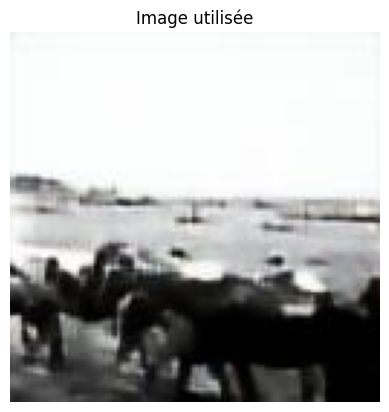

In [70]:
#import glob
image_files = glob(f"{DENOISED_PHOTOS_DIRECTORY}/photo*.jpg")
image = random.choice(image_files)

#Choisir une image aléatoire
valid_captions_LSTM = []

# Boucle jusqu'à obtenir 5 captions valides par modèle
while len(valid_captions_LSTM) < 5 :
    result_LSTM, attention_plot_LSTM = evaluate(image, decoderLSTM)

    predicted_caption_LSTM = ' '.join([word for word in result_LSTM if word not in ['<start>', '<end>']])

    if len(valid_captions_LSTM) < 5 and is_valid_caption(predicted_caption_LSTM):
        valid_captions_LSTM.append((predicted_caption_LSTM, attention_plot_LSTM))

# Affichage final
print('Image Path:', image)
#print('Real Caption:', real_caption)

# Affichage LSTM
print('LSTM Predictions:')
for i, (caption, attn) in enumerate(valid_captions_LSTM, 1):
    print(f'LSTM Prediction {i}:', caption)
    #plot_attention(image, caption.split(), attn)

# Afficher l'image originale
img = Image.open(image)
plt.imshow(img)
plt.axis("off")
plt.title("Image utilisée")
plt.show()

Image Path: final_pipeline/photos\photo_3648.jpg
LSTM Predictions:
LSTM Prediction 1: two view are are next on a ground skateboard and a large bench
LSTM Prediction 2: two view next on a shower behind a ground fedora wedding
LSTM Prediction 3: young toddler a skateboard two view and young ovens
LSTM Prediction 4: two people are are next on a ground fedora girls behind the skateboard
LSTM Prediction 5: two people are are next on a shower her a some reflection


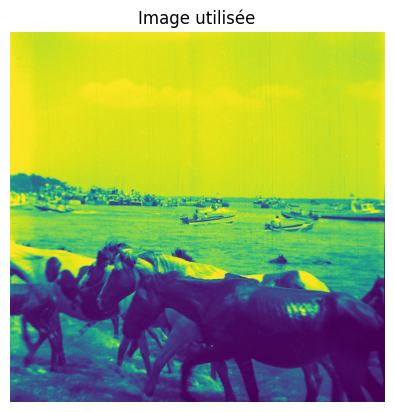

In [71]:
clean_img = image.replace("denoised_photos", "photos")

#Choisir une image aléatoire
valid_captions_LSTM = []

# Boucle jusqu'à obtenir 5 captions valides par modèle
while len(valid_captions_LSTM) < 5 :
    result_LSTM, attention_plot_LSTM = evaluate(clean_img, decoderLSTM)

    predicted_caption_LSTM = ' '.join([word for word in result_LSTM if word not in ['<start>', '<end>']])

    if len(valid_captions_LSTM) < 5 and is_valid_caption(predicted_caption_LSTM):
        valid_captions_LSTM.append((predicted_caption_LSTM, attention_plot_LSTM))

# Affichage final
print('Image Path:', clean_img)
#print('Real Caption:', real_caption)

# Affichage LSTM
print('LSTM Predictions:')
for i, (caption, attn) in enumerate(valid_captions_LSTM, 1):
    print(f'LSTM Prediction {i}:', caption)

# Afficher l'image originale
img = Image.open(clean_img)
plt.imshow(img)
plt.axis("off")
plt.title("Image utilisée")
plt.show()